In [1]:
# Operating system interfaces
import os 
# Library for real-time computer vision
import cv2
# Plot library
import matplotlib.pyplot as plt
# Operations on matrices
import numpy as np
# Deep learning library
import tensorflow as tf
# Track time
import time
# Pandas table dataframes
import pandas as pd
# Plot movie frames on Google Colab
from google.colab.patches import cv2_imshow
# Install and import EfficientNet
!pip install EfficientNet
from efficientnet.tfkeras import EfficientNetB0

     |████████████████████████████████| 51kB 3.6MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!rm -rf images
!mkdir images
!du -hs images

cap = cv2.VideoCapture('/content/drive/My Drive/Trento/Data/500days.mp4')

path = '/content/images'


for i in range(0,int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), int(cap.get(cv2.CAP_PROP_FPS))):
  
    ret, frame = cap.read()

    # Resize the 1280 x 720 resolution frames to 398 x 224 (to maintain ratio)
    # Then clip the frames to get 224 x 224 CNN inputs

    dim = (398, 224)

    resized = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    crop_img = resized[: , int(87):int(311)]

    if ret == False:
        break
    cv2.imwrite(os.path.join(path, str(i) +'.jpg'), crop_img)
 
cap.release()
cv2.destroyAllWindows()

4.0K	images


In [4]:
model = EfficientNetB0(weights='imagenet', include_top=False, pooling="avg")
model.summary()

16809984/16804768 [==============================] - 0s 0us/step
Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
___________________

21831680/21826536 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 864
Trainable params: 864
Non-trainable params: 0
_________________________________________________________________


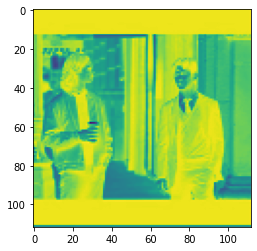

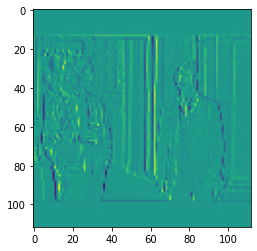

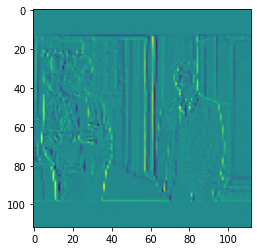

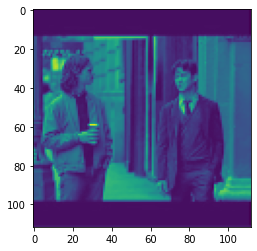

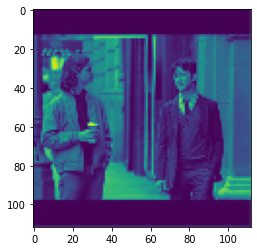

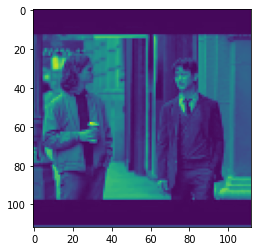

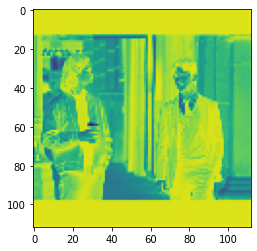

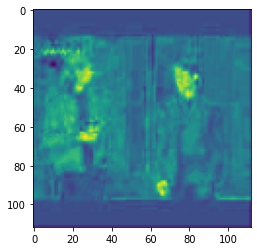

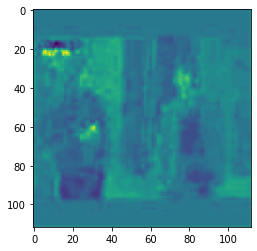

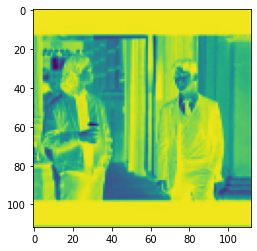

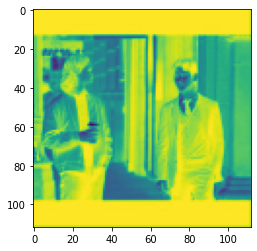

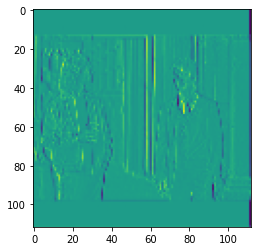

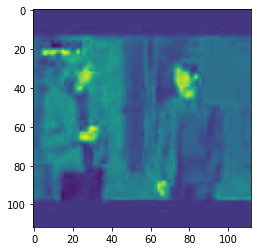

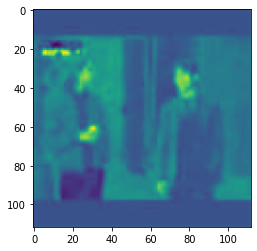

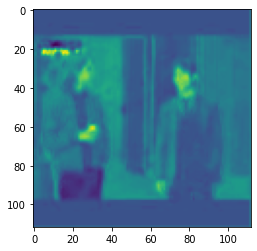

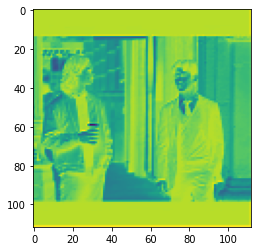

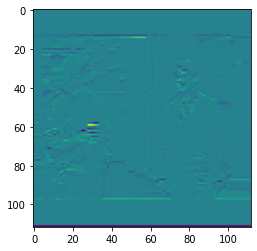

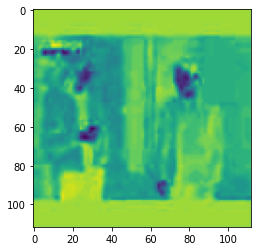

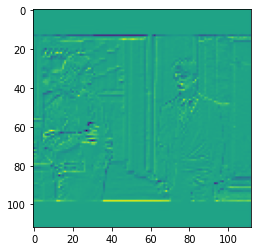

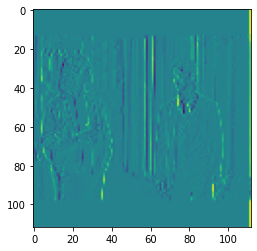

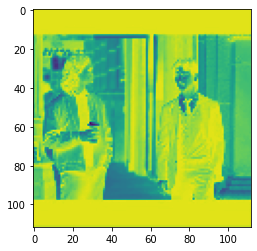

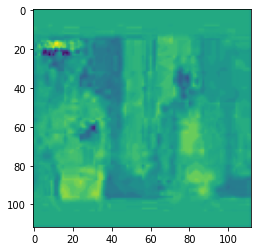

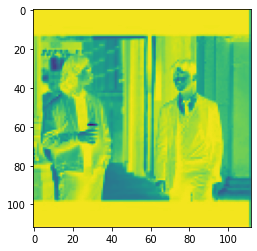

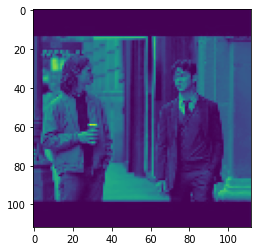

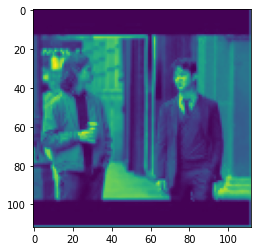

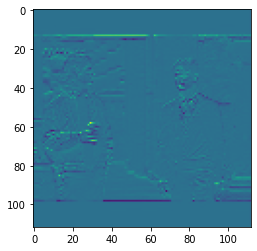

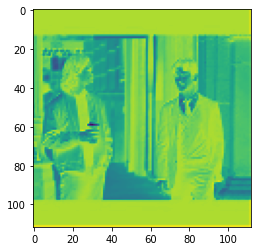

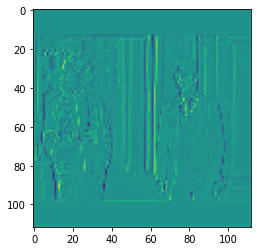

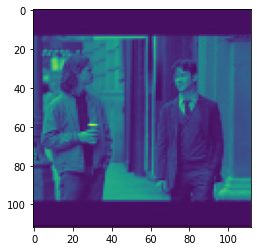

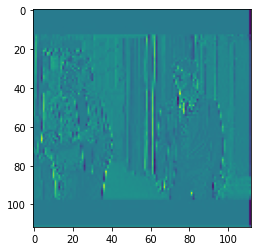

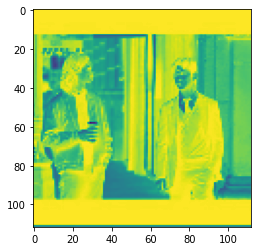

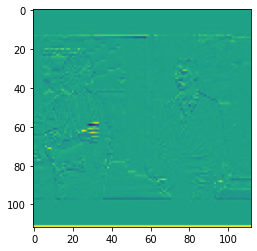

In [5]:
# plot feature map of first conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = EfficientNetB0()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# load the image with the required shape
img = load_img('/content/images/0.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# # plot all 32 maps
for i in range(0,32):
  pyplot.imshow(feature_maps[0, :, :, i])
  pyplot.show()

In [6]:
j=0
fmaps= np.zeros((621,1, 112, 112, 32))

for i in range(0,18630,30):

  # load the image with the required shape
  img = load_img("/content/images/" + str(i) + ".jpg", target_size=(224, 224))
  # convert the image to an array
  img = img_to_array(img)
  # expand dimensions so that it represents a single 'sample'
  img = expand_dims(img, axis=0)
  # prepare the image (e.g. scale pixel values)
  img = preprocess_input(img)
  # get feature map for first hidden layer
  fmaps[j] = model.predict(img)
  j+=1

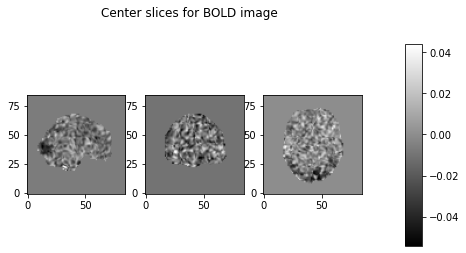

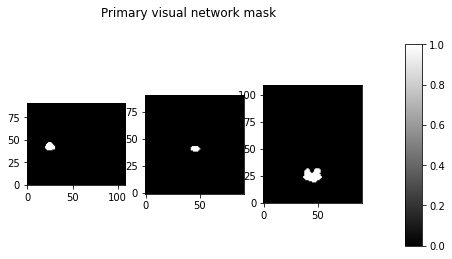

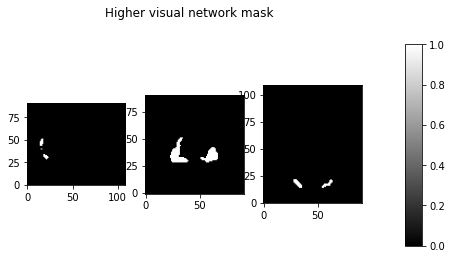

In [7]:
# Load the BOLD image dataset
import nibabel as nib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

img = nib.load('/content/drive/My Drive/Trento/Data/500daysclip_fMRI.nii.gz')
img = img.get_fdata()

def show_slices(slices, color):
   """ Function to display row of image slices """

   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       im = axes[i].imshow(slice.T, cmap=color, origin="lower")
       cbar_ax = fig.add_axes([1.0, 0.15, 0.04, 0.7])
       
       if i == 2:
         fig.colorbar(im, cax=cbar_ax)

slice_0 = img[42, :, :, 0]
slice_1 = img[:, 42, :, 0]
slice_2 = img[:, :, 42, 0]
show_slices([slice_0, slice_1, slice_2], color='gray')
plt.suptitle("Center slices for BOLD image");

# Functional network masks obtained from:
# https://findlab.stanford.edu/functional_ROIs.html

mask1 = nib.load('/content/drive/My Drive/Trento/Data/primary_visual.nii')
mask1 = mask1.get_fdata()
mask1 = np.asarray(mask1)

slice_0 = mask1[42, :, :]
slice_1 = mask1[:, 20, :]
slice_2 = mask1[:, :, 42]
show_slices([slice_0, slice_1, slice_2], color='gray')
plt.suptitle("Primary visual network mask");

mask2 = nib.load('/content/drive/My Drive/Trento/Data/higher_visual.nii')
mask2 = mask2.get_fdata()
mask2 = np.asarray(mask2)

slice_0 = mask2[36, :, :]
slice_1 = mask2[:, 20, :]
slice_2 = mask2[:, :, 42]
show_slices([slice_0, slice_1, slice_2], color='gray')
plt.suptitle("Higher visual network mask");

In [8]:
fmaps.shape

(621, 1, 112, 112, 32)

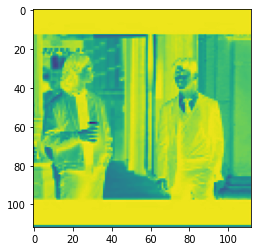

(600, 1, 112, 112)

In [9]:
# Test the first feature map. Try different ones (some of them look similar)
pyplot.imshow(fmaps[0, 0, :, :, 0])
pyplot.show()

onefmap = fmaps[:600, :, :, :, 0]
onefmap.shape

In [10]:
# Check variables in memory
import sys
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                           img:  2.7 GiB
                         fmaps:  1.9 GiB
                         frame:  2.6 MiB
                  feature_maps:  1.5 MiB
                       resized: 261.3 KiB
                          _iii:  1.5 KiB
                           _i7:  1.5 KiB
                           _i5:  1.1 KiB
                         Model:  1.0 KiB
                           _i3:  726.0 B


In [11]:
from scipy.stats import pearsonr, zscore
from sklearn.linear_model import LinearRegression

dim1 = img.shape[0]
dim2 = img.shape[1]
dim3 = img.shape[2]

ccoef = np.zeros(32)

# Partition screen into 9x9 subframes

# R = np.zeros((dim1, dim2, dim3, 9, 9, 32))
m = np.zeros((dim1, dim2, dim3, 9, 9, 32))

for i in range(0, dim1):
  for j in range(0, dim2):
    for k in range(0, dim3):

# Select mask1 for primary visual cortex or mask2 for higher visual cortex

      if mask1[i,j,k] != 0:

        y = img[i,j,k,:]

        
        for w in range(9):
          for s in range(9):

           for f in range(32):
              # R[i, j, k, w, s, f] = pearsonr(fmaps[:600,0,w*12,s*12,f], y[:600])[0]
              regressor = LinearRegression()
              regressor.fit(fmaps[:600,0,w*12,s*12,f].reshape(-1, 1), zscore(y[:600]))
              m[i, j, k, w, s, f] = regressor.coef_

In [12]:
# del img
# del fmaps

In [13]:
# where_are_NaNs = np.isnan(R)
# R[where_are_NaNs] = 0
# R1 = R.reshape(85*85*85,9,9,32)
# nonzeroind = np.unique(np.nonzero(R1)[0])

where_are_NaNs = np.isnan(m)
m[where_are_NaNs] = 0
R1 = m.reshape(85*85*85,9,9,32)
nonzeroind = np.unique(np.nonzero(R1)[0])

p = 0

list = [[]]

for i in nonzeroind:

  R2 = R1[i,:,:,:]
  coord = np.unravel_index(R2.argmax(), R2.shape)
  v1 = coord[0] - 4
  v2 = coord[1] - 4
  
  if coord[0] > 4 and coord[1] > 4:
    list.append([p,'Q1', np.angle(v1+v2*1j, deg=True), np.sqrt(v1**2+v2**2), coord[2], R2[coord]])
    p += 1
    continue

  if coord[0] < 4 and coord[1] > 4:
    list.append([p,'Q2', np.angle(v1+v2*1j, deg=True), np.sqrt(v1**2+v2**2), coord[2], R2[coord]])
    p += 1
    continue

  if coord[0] < 4 and coord[1] < 4:
    list.append([p,'Q3', np.angle(v1+v2*1j, deg=True), np.sqrt(v1**2+v2**2), coord[2], R2[coord]])
    p += 1
    continue

  if coord[0] > 4 and coord[1] < 4:
    list.append([p,'Q4', np.angle(v1+v2*1j, deg=True), np.sqrt(v1**2+v2**2), coord[2], R2[coord]])
    p += 1
    continue

  list.append([p,'C', np.angle(v1+v2*1j, deg=True), np.sqrt(v1**2+v2**2), coord[2], R2[coord]])
  p += 1
  
import pandas as pd

# df = pd.DataFrame(list,columns=['Voxel','Screen region','Angle','Radius','Feature map', 'R'])[1:]
df = pd.DataFrame(list,columns=['Voxel','Screen region','Angle','Radius','Feature map', 'Beta'])[1:]
df

Voxel Screen region       Angle    Radius  Feature map          Beta
1        0.0            Q3 -146.309932  3.605551         28.0  2.681597e+06
2        1.0            Q2  161.565051  3.162278         28.0  3.382668e+06
3        2.0            Q3 -161.565051  3.162278         28.0  3.048092e+06
4        3.0            Q3 -126.869898  5.000000         28.0  3.910152e+06
5        4.0            Q3 -126.869898  5.000000         28.0  3.014952e+06
...      ...           ...         ...       ...          ...           ...
1116  1115.0            Q3 -126.869898  5.000000         28.0  4.363928e+06
1117  1116.0            Q2  108.434949  3.162278         28.0  5.104071e+04
1118  1117.0             C  180.000000  3.000000         28.0  3.485423e+06
1119  1118.0            Q2  146.309932  3.605551         28.0  1.894551e+06
1120  1119.0            Q2  126.869898  5.000000         28.0  4.526845e+06

[1120 rows x 6 columns]

In [14]:
for i in range(0, dim1):
  for j in range(0, dim2):
    for k in range(0, dim3):

# Select mask1 for primary visual cortex or mask2 for higher visual cortex

      if mask1[i,j,k] != 0:

        y = img[i,j,k,:]

        
        for w in range(9):
          for s in range(9):

           for f in range(32):
              # R[i, j, k, w, s, f] = pearsonr(fmaps[:600,0,w*12,s*12,f], y[:600])[0]
              regressor = LinearRegression()
              regressor.fit(fmaps[:600,0,w*12,s*12,f].reshape(-1, 1), zscore(y[:600]))
              m[i, j, k, w, s, f] = regressor.intercept_

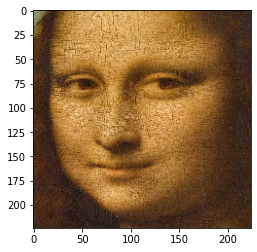

In [15]:
# load a sample image

import urllib.request
urllib.request.urlretrieve("https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/MonaLisa_sfumato.jpeg/515px-MonaLisa_sfumato.jpeg", "monalisa.jpg")

# load the image with the required shape
img = load_img('/content/monalisa.jpg', target_size=(224, 224))

pyplot.imshow(img)
pyplot.show()

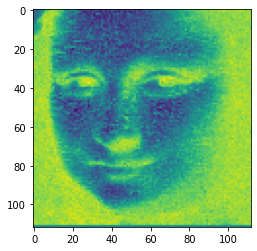

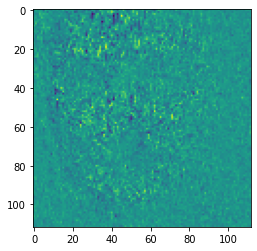

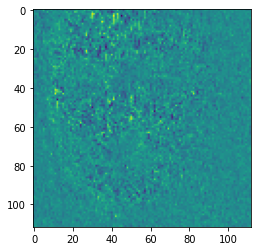

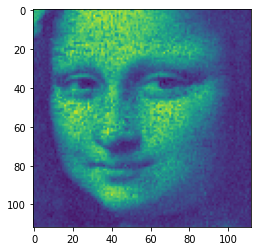

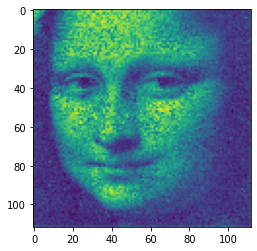

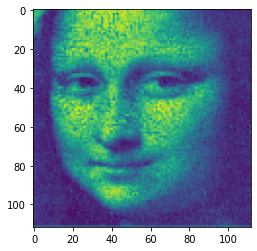

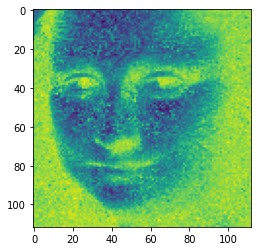

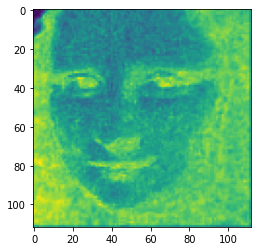

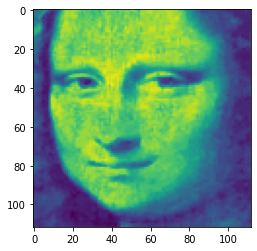

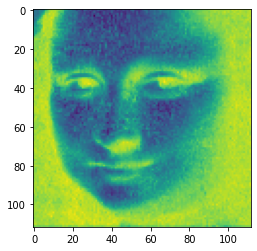

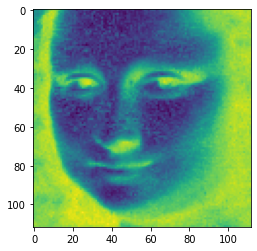

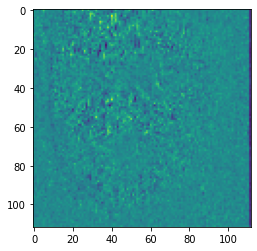

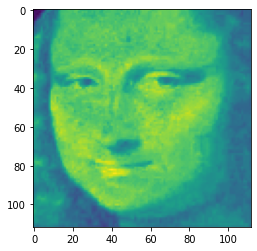

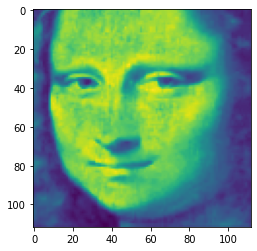

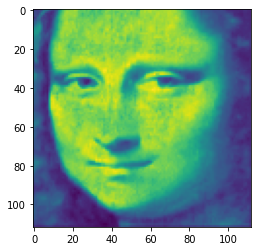

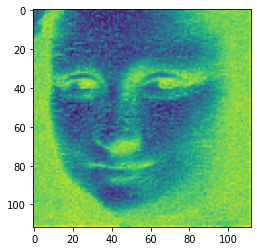

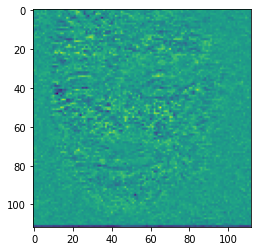

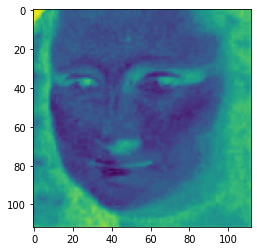

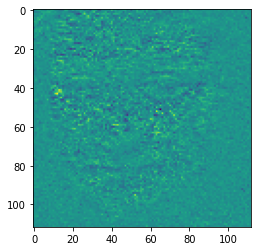

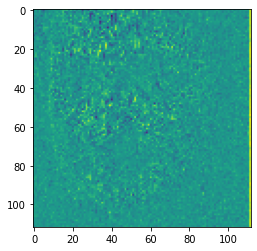

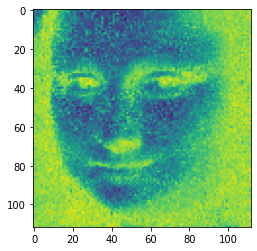

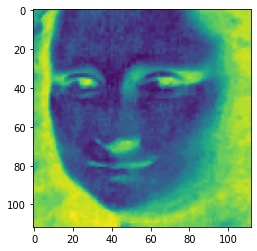

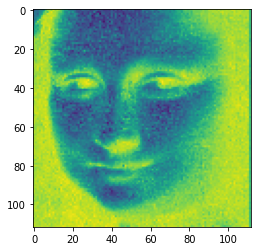

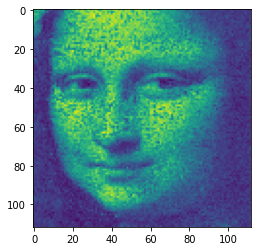

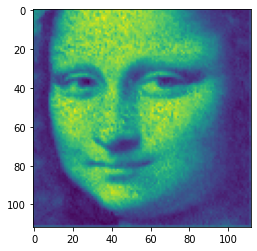

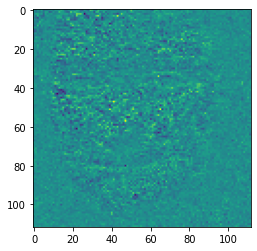

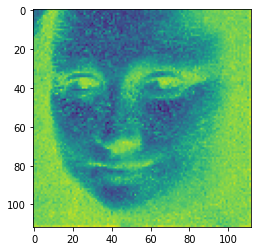

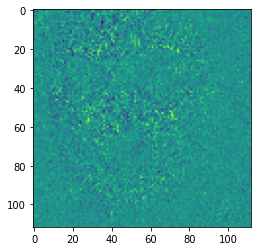

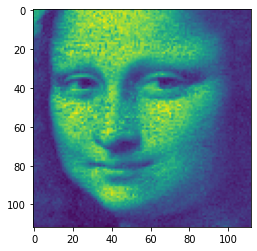

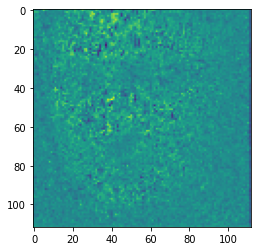

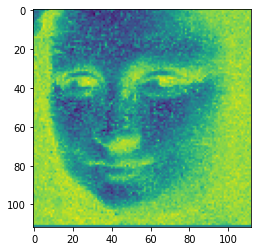

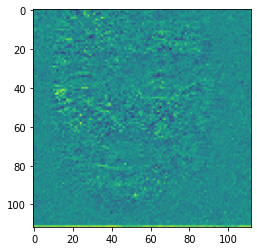

In [16]:
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# # plot all 32 maps
for i in range(0,32):
  pyplot.imshow(feature_maps[0, :, :, i])
  pyplot.show()

In [17]:
c=-1

for i in range(0, dim1):
  for j in range(0, dim2):
    for k in range(0, dim3):

# Select mask1 for primary visual cortex or mask2 for higher visual cortex

      if mask1[i,j,k] != 0:
        
        c = c+1
        
        for w in range(9):
          for s in range(9):

           for f in range(32):
             # New input * beta + intercept
              m[i, j, k, w, s, f] = feature_maps[0,w*12,s*12,f]*df.iloc[c,5] + m[i, j, k, w, s, f]

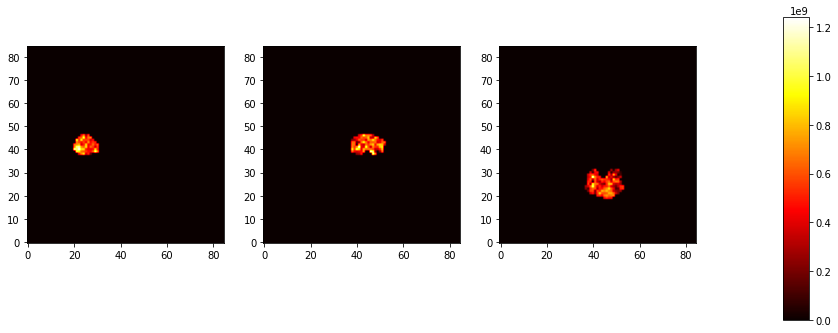

In [18]:
import seaborn as sns

def show_slices(slices, color):
   """ Function to display row of image slices """

   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       im = axes[i].imshow(slice.T, cmap=color, origin="lower")
       fig.set_size_inches(12,12)
       cbar_ax = fig.add_axes([1.0, 0.30, 0.03, 0.35])
       if i == 2:
         fig.colorbar(im, cax=cbar_ax)

#  Prediction of activation looking at the center of the image

slice_0 = m[42, :, :, 0, 0, 13]
slice_1 = m[:, 26, :, 0, 0, 13]
slice_2 = m[:, :, 42, 0, 0, 13]
show_slices([slice_0, slice_1, slice_2], color='hot')